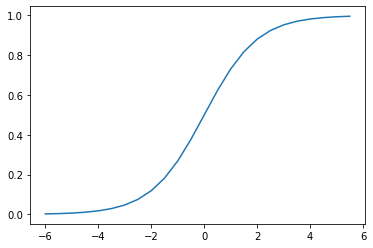

In [11]:
import numpy as np
from typing import Tuple, Optional, Union

from tensorflow.keras.losses import binary_crossentropy, mean_squared_error
import tensorflow as tf

import matplotlib.pyplot as plt

from mlp import DenseLayer, MLP
from ops import ReLU, MeanSquaredError, BinaryCrossEntropy, Sigmoid

np.random.seed(0)

In [19]:
def deriv_bce(y, y_hat):
    if y == 1:
        return -1 / y_hat
    else:
        return 1 / (1 - y_hat)

In [24]:
# Stack overflow
from typing import Optional, Union

import numpy as np

from tensorflow.keras.losses import binary_crossentropy, mean_squared_error
import tensorflow as tf


class MeanSquaredError:
    """Mean squared error cost (loss) function.

    The predictions are the activations of the network. The order of
    arguments in the `derivative` was based on
    `Four fundamental equations behind backpropagation` from
    Nielsen (Ch.2, 2015). Similarly, the gradient calculation in BP1a of 
    is described in the same resource.
    """

    def gradient(
            self, inputs: tuple[np.ndarray, np.ndarray]) -> np.ndarray:
        """Computes the gradient with respect to all activations (preds).

        This is a vectorized function and is called on each element of 
        an activation vector in order to compute the partial derivative
        of the cost with respect to the j^{th} activation for the 
        l^{th} layer.

        MSE = (1/dims) * (pred - true)^{2}
        dMSE/dPred =  (2/dim) * (pred - true)

        Args:
            inputs: Targets, predictions vectors.

        Returns:
            Vector (gradient) of values.
        """

        targets, predictions = inputs
        return (2 / targets.shape[-1]) * (predictions - targets)

    def __call__(
            self,
            inputs: tuple[np.ndarray, np.ndarray],
            axis: Optional[int] = None) -> np.float64:
        """Compute cost given inputs.

        Args:
            inputs: Targets and predictions vectors.

        Return:
            Scalar cost.
        """

        targets, predictions = inputs
        return np.mean(np.square(targets - predictions), axis=axis)

class BinaryCrossEntropy:
    """Binary cross entropy loss (cost) function."""

    def __init__(self, from_logits: bool = False):
        """Initializes sigmoid function for binary cross entropy.

        Args:
         from_logits: True for logits, false for normalized log 
                probabilities (i.e., used sigmoid activation function).
                Assumes not from logits.
        """

        self.sigmoid = lambda t: 1 / (1 + np.exp(-t))
        self.from_logits = from_logits

    def gradient(self, inputs: tuple[np.ndarray, np.ndarray]) -> np.ndarray:
        """Derivative with respect to a single activation (same as derivative).

        Should there be a from logits check here??

        Args:
            inputs: Targets, predictions vectors. Presumably, the inputs 
            here also have to be normalized log probabilities.

        Returns:
            Vector (gradient) of values.
        """
        targets, predictions = inputs

        if self.from_logits:
            predictions = self.sigmoid(predictions)

        return -1 * ((targets/predictions) - ((1-targets) / (1-predictions)))

    def __call__(self,
                 inputs: tuple[np.ndarray, np.ndarray],
                 axis: Optional[int] = None) -> np.ndarray:
        """Compute cost given inputs.

        Args:
            inputs: Targets and predictions vectors. 
                Assumes predictions are not from logits.

        Return:
            Scalar cost.
        """

        targets, predictions = inputs

        if self.from_logits:
            predictions = self.sigmoid(predictions)

        return -1 * np.mean(targets * np.log(predictions) + (1 - targets) * np.log(1 - predictions), axis=axis)

# MSE gradient example

# Instantiate cost function objects
mse = MeanSquaredError()
bce = BinaryCrossEntropy()

# Validate MSE grad
a_L_np = np.array([0.12, 0.35, 0.61])
y_true_np = np.array([0.11, 0.01, 0.59])
a_L_tf = tf.Variable(a_L_np)
y_true_tf = tf.constant(y_true_np)

# tf gradient context
with tf.GradientTape() as tape:
    C = mean_squared_error(y_true=y_true_tf, y_pred=a_L_tf)

dC_daL = tape.gradient(C, a_L_tf)
print('-- MSE -- ')
print('tf gradient tape:', dC_daL.numpy())

# My implementation
dC_daL_np = mse.gradient((y_true_np, a_L_np))
print('mse.gradient:', dC_daL_np)
print()

#### BCE ####
y_true = tf.constant(np.array([0., 1., 0., 0.]))
y_pred_logits = np.array([-18.6, 0.51, 2.94, -12.8])
y_pred_proba = tf.Variable(sigmoid(y_pred_logits))

with tf.GradientTape() as tape:
    C = binary_crossentropy(y_true, y_pred_proba)

print('-- BCE --')
dC_dProbaActivation = tape.gradient(C, y_pred_proba)
print('tf gradient tape:', dC_dProbaActivation.numpy())
dC_dProbaActivationMine = bce.gradient((y_true, y_pred_proba))
print('bce.gradient:', dC_dProbaActivationMine.numpy())
print('ml master deriv bce:', [deriv_bce(y_true[sample].numpy(), y_pred_proba[sample].numpy()) for sample in range(y_true.shape[0])])

#### Outputs ####
# -- MSE -- 
# tf gradient tape: [0.00666667 0.22666667 0.01333333]
# mse.gradient: [0.00666667 0.22666667 0.01333333]

# -- BCE --
# tf gradient tape: [ 0.         -0.40012383  4.97895166  0.25000067]
# bce.gradient: [ 1.00000001 -1.60049558 19.91584631  1.00000276]

-- MSE -- 
tf gradient tape: [0.00666667 0.22666667 0.01333333]
mse.gradient: [0.00666667 0.22666667 0.01333333]

-- BCE --
tf gradient tape: [ 0.         -0.40012383  4.97895166  0.25000067]
bce.gradient: [ 1.00000001 -1.60049558 19.91584631  1.00000276]
ml master deriv bce: [1.00000000835839, -1.600495578812266, 19.915846312255084, 1.000002760772572]


In [ ]:
# Tf gradient stock example
# https://www.tensorflow.org/api_docs/python/tf/GradientTape
# Here goes the neural network weights as tf.Variable
x = tf.Variable([3.0, 5])

def dydx(var):
    """y = x^{2}, dydx = 2x"""

    return 2 * var

# TensorFlow operations executed within the context of
# a GradientTape are  recorded for differentiation 
with tf.GradientTape() as tape:
  # Doing the computation in the context of the gradient tape
  # For example computing loss
  y = x ** 2 

# Getting the gradient of network weights w.r.t. loss
dy_dx = tape.gradient(y, x) 
my_dy_dx = dydx(x.numpy())
print(dy_dx)  # Returns 6
print(my_dy_dx)

In [2]:
# MSE example
y_true = tf.constant(np.array([[0.1234, 1., 123], [0.346, 0., 123]]))
y_pred = tf.Variable(np.array([[1., 1., 0], [1., 0., 0]]))

print(y_true.shape)

mse = MeanSquaredError()
print(mean_squared_error(y_true, y_pred))
print(mse((y_true, y_pred), axis=-1))
print()

with tf.GradientTape() as tape:
    C = mean_squared_error(y_true, y_pred)

print(tape.gradient(C, y_pred))
print(mse.gradient((y_true, y_pred)))

(2, 3)
tf.Tensor([5043.25614252 5043.142572  ], shape=(2,), dtype=float64)
[5043.25614252 5043.142572  ]

tf.Tensor(
[[  0.5844   0.     -82.    ]
 [  0.436    0.     -82.    ]], shape=(2, 3), dtype=float64)
tf.Tensor(
[[  0.5844   0.     -82.    ]
 [  0.436    0.     -82.    ]], shape=(2, 3), dtype=float64)


In [4]:
# MSE gradient example

# Instantiate mse object
mse = MeanSquaredError()

# Validate MSE grad
a_L_np = np.array([0.12, 0.35, 0.61])
y_true_np = np.array([0.11, 0.01, 0.59])
a_L_tf = tf.Variable(a_L_np)
y_true_tf = tf.constant(y_true_np)

# tf gradient context
with tf.GradientTape() as tape:
    C = mean_squared_error(y_true=y_true_tf, y_pred=a_L_tf)

dC_daL = tape.gradient(C, a_L_tf)
print('tf gradient tape:', dC_daL.numpy())

# My implementation
dC_daL_np = mse.gradient((y_true_np, a_L_np))
print('mse.gradient:', dC_daL_np)

tf gradient tape: [0.00666667 0.22666667 0.01333333]
mse.gradient: [0.00666667 0.22666667 0.01333333]


In [5]:
# BCE example

samples = 5
dims = 4

sigmoid = Sigmoid()

y_true = np.array([0, 1, 0, 0])
print('mean (axis=None)', np.mean(y_true, axis=None))
print('mean axis=-1:', np.mean(y_true, axis=-1))
y_pred_logits = np.array([-18.6, 0.51, 2.94, -12.8])
y_pred_proba = sigmoid(y_pred_logits)

random_true = np.random.choice(a=2, size=(samples, dims))
random_proba = sigmoid(np.random.normal(size=(samples, dims)))

print('Inputs:')
print('y_true:', y_true)
print('y_pred_logits:', y_pred_logits)
print('y_pred_proba:', y_pred_proba)

bce_fl = BinaryCrossEntropy(from_logits=True)
bce = BinaryCrossEntropy()

print()
print('My implementation:')
print('bce(from_logits=False):', bce((y_true, y_pred_proba)))
print('bce(from_logits=True):', bce_fl((y_true, y_pred_logits)))

print()
print('Tensorflow:')
print(binary_crossentropy(y_true, y_pred_proba).numpy())

print()
print('Random Calculations:')
print('TensorFlow:', tf.reduce_mean(binary_crossentropy(y_true=random_true, y_pred=random_proba)))
print('My Implementation:', bce((random_true, random_proba)))

mean (axis=None) 0.25
mean axis=-1: 0.25
Inputs:
y_true: [0 1 0 0]
y_pred_logits: [-18.6    0.51   2.94 -12.8 ]
y_pred_proba: [8.35839003e-09 6.24806474e-01 9.49788727e-01 2.76076495e-06]

My implementation:
bce(from_logits=False): 0.8654579497810978
bce(from_logits=True): 0.8654579497810978

Tensorflow:
0.8654573847833843

Random Calculations:
TensorFlow: tf.Tensor(0.8897597402544937, shape=(), dtype=float64)
My Implementation: 0.8897600640814369


In [18]:
# BCE gradient example

samples = 5
dims = 4

sigmoid = Sigmoid()
bce = BinaryCrossEntropy()

y_true = tf.constant(np.array([0., 1., 0., 0.]))
y_pred_logits = np.array([-18.6, 0.5, 2.94, -12.8])
y_pred_proba = tf.Variable(sigmoid(y_pred_logits))
y_pred_single_proba = np.array([0.5])
y_true_single_response = np.array(1.)

random_true = np.random.choice(a=2, size=(samples, dims))

with tf.GradientTape() as tape:
    C = binary_crossentropy(y_true, y_pred_proba)

print('TensorFlow:')
dC_dProbaActivation = tape.gradient(C, y_pred_proba)
print(dC_dProbaActivation)
print()

print('My Implementation:')
dC_dProbaActivationMine = bce.gradient((y_true, y_pred_proba))
print(dC_dProbaActivationMine)

print(bce.gradient((y_true_single_response, y_pred_single_proba)))

TensorFlow:
tf.Tensor([ 0.         -0.4016326   4.97895166  0.25000067], shape=(4,), dtype=float64)

My Implementation:
tf.Tensor([ 1.00000001 -1.60653066 19.91584631  1.00000276], shape=(4,), dtype=float64)
[-2.]


In [4]:
# X matrix
batch_size = 4

X = np.random.normal(size=(16, 1))

num_samples = X.shape[0]
num_batches = num_samples//batch_size
batch_indices = np.random.choice(num_samples, size=(num_batches, batch_size))

print(batch_indices, batch_indices.shape)
print(X, X.shape)
print(X[batch_indices].shape)
print()

for batch in X[batch_indices]:
    print(batch)

[[14  2 11  0]
 [14  3  5 12]
 [ 9 10  4 11]
 [ 4  6  4 15]] (4, 4)
[[ 0.8644362 ]
 [-0.74216502]
 [ 2.26975462]
 [-1.45436567]
 [ 0.04575852]
 [-0.18718385]
 [ 1.53277921]
 [ 1.46935877]
 [ 0.15494743]
 [ 0.37816252]
 [-0.88778575]
 [-1.98079647]
 [-0.34791215]
 [ 0.15634897]
 [ 1.23029068]
 [ 1.20237985]] (16, 1)
(4, 4, 1)

[[ 1.23029068]
 [ 2.26975462]
 [-1.98079647]
 [ 0.8644362 ]]
[[ 1.23029068]
 [-1.45436567]
 [-0.18718385]
 [-0.34791215]]
[[ 0.37816252]
 [-0.88778575]
 [ 0.04575852]
 [-1.98079647]]
[[0.04575852]
 [1.53277921]
 [0.04575852]
 [1.20237985]]


In [ ]:
targets = 1
batch_size = 32
A = np.random.normal(size=(batch_size, targets))
y_true = np.random.normal(size=(batch_size, targets))
Z = np.random.normal(size=(batch_size, targets))

def compute_delta_L(a, y, z):
    """"""
    return np.random.choice(size=(z.shape[0]))

delta_L = np.apply_along_axis()

In [ ]:
# (W^{l+1}_jk)^T DOT d_^{l+1}j HADAMARD phi(z_j)
# C_k1 HADAMARD 
# j = num_neurons_in_cur_layer = 2
# k = num_neurons_in_prev_layer = 3
# o         o     
#           o          o
# o         o 
#       j=3, k=2    j=1, k=3
# (W^{l+1}_13)^T DOT d^{l+1}_1 H phi(z_3)
# W^{l+1}_31 DOT d^{l+1}_1 H phi(z_3)
# C_3 H Phi(z_3)

In [3]:
a = np.random.normal(size=(32, 1))
b = np.random.normal(size=(32, 1))
c = np.random.normal(size=(32,))

print(np.atleast_2d(c).shape)

print(np.transpose(a).shape)
print(np.transpose(c).shape)

(1, 32)
(1, 32)
(32,)


In [5]:
x = np.arange(0, 5)
y = np.full_like(x, fill_value=2)

print(x)
print('hadamard', x * y)
print(np.dot(x, y))

[0 1 2 3 4]
hadamard [0 2 4 6 8]
20


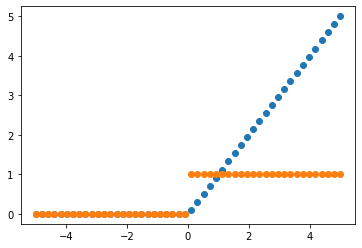

In [7]:
x = np.linspace(-5, 5)
y = ReLU()(x)
dydx = ReLU().derivative(x)
plt.scatter(x, y)
plt.scatter(x, dydx)

In [8]:
# Input data
rows = 5
cols = 10
input_vector = np.random.normal(size=(rows, cols))
dummy_pred_vector = np.random.normal(size=(rows, cols))

In [9]:
# Instantiate Layer
lyr = DenseLayer(input_dims=input_vector.shape[-1], num_units=2)

In [10]:
# Layer call
lyr_activations, lyr_wt_inputs = lyr(input_vector)
print('input:', input_vector.shape)
print('output:', lyr_activations.shape, lyr_wt_inputs.shape)
print(lyr_activations, '\n\n', lyr_wt_inputs)

input: (5, 10)
output: (5, 2) (5, 2)
[[-0.42647349 -0.24779502]
 [-0.28689659 -0.40105034]
 [-0.32231351 -0.45992227]
 [-0.18448811  0.24800787]
 [ 0.17294692  0.21348298]] 

 [[-0.42647349 -0.24779502]
 [-0.28689659 -0.40105034]
 [-0.32231351 -0.45992227]
 [-0.18448811  0.24800787]
 [ 0.17294692  0.21348298]]


In [13]:
model = MLP(input_dims=input_vector.shape[-1], hidden_units=2, targets=1, loss_function=mse, learning_rate=1e-3, l_layers=2)

([], [])

In [20]:
# Result of forward pass
fwd = model._forward_pass(inputs=input_vector)
print(fwd)
print(fwd.shape)

[[ 0.13224191]
 [ 0.01783743]
 [-0.16562248]
 [-0.15245786]
 [-0.05169993]]
(5, 1)


In [ ]:
batch_size = 32
samples = 100
y_batch_indices = np.random.choice(
            a=samples, size=(samples//batch_size, batch_size), replace=False) 

3
[[22 51 90 17 94 76 89 87  8 53 98 55 50 31 26 28 88 79 34 74 39 85 12 16
  83 64 20 67 58 77 25  7]
 [86 36 21 72 84 57  9 11 96 82 68 49  5 14 15 37 19 33 69 78 59 56  4 91
  75  6 95 44 65 62 29 40]
 [71 24 81 41 73 45 13 23 42 52 92 38 63 60  2 46 70 93 32  3  0 80 97 99
   1 30 48 27 47 43 18 10]]
